# Data Challenge - Advanced Machine Learning


**The data challenge is proposed by Idemia**

## Description of the data challenge

You have at your disposal 100000 images of human faces, and their occlusion label.
The goal of this challenge is to regress the percentage of the face that is occluded.
We also want to have similar performances on female and male, the gender label is given for the train database.

Below is the formula of the evaluation score. You'll first need to compute the error made by your model for men and women separetely. The error is measured as follows

$$
 Err = \frac{\sum_{i}{w_i(p_i - GT_i)^2}}{\sum_{i}{w_i}}, w_i = \frac{1}{30} + GT_i,
$$
where $GT_i$ is the ground truth and p_i the prediction made by your model. 

Then, the final score for the leaderboard is given by

$$
Score = \frac{Err_F + Err_M}{2} + \left | Err_F - Err_M \right |,
$$
where $Err_F$ and $Err_M$ are the errors obtained for female and men, respectively.

Hereafter we show you how to load the data and run a naive baseline using a pretrained model.

### Downloading the Data:

You can download the Dataset from the below links: https://partage.imt.fr/index.php/s/mscQABX4oZxx7ax

In [48]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

### Load dataframes

In [49]:
df_train = pd.read_csv("listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "crops_100K"

In [3]:
df_train.tail()

,filename,FaceOcclusion,gender
101340,database3/database3/m.01drbr/85-FaceId-0_align...,0.017,1.000
101341,database3/database3/m.01drbr/86-FaceId-0_align...,0.152,1.000
101342,database3/database3/m.01drbr/87-FaceId-0_align...,0.004,0.999
101343,database3/database3/m.01drbr/90-FaceId-0_align...,0.012,1.000
101344,database3/database3/m.01drbr/92-FaceId-0_align...,0.036,1.000


In [4]:
df_test.head()

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg


#### Remove nan values

In [5]:
df_train = df_train.dropna()
df_test = df_test.dropna()

### Split Dataframe in train and val

In [6]:
df_val = df_train.loc[:20000].reset_index()
df_train = df_train.loc[20000:].reset_index()

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split

# 假设 df_train 已经加载

# 随机打乱数据集
df_train_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# 将数据集分割为训练集和验证集，80% 用于训练，20% 用于验证
df_train, df_val = train_test_split(df_train_shuffled, test_size=0.2, random_state=42)

# 重置索引
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# 查看结果
print("Training set:")
print(df_train.head())
print("\nValidation set:")
print(df_val.head())

Training set:
                                            filename  FaceOcclusion  gender
0                          database1/img00015966.jpg          0.015   0.997
1  database3/database3/m.0178tj/101-FaceId-0_alig...          0.009   0.999
2  database3/database3/m.01cw0m/32-FaceId-0_align...          0.288   0.994
3                          database1/img00017957.jpg          0.351   0.001
4                          database1/img00020727.jpg          0.128   0.001

Validation set:
                                            filename  FaceOcclusion  gender
0  database3/database3/m.01cj1t/7-FaceId-0_align.jpg          0.122   1.000
1  database3/database3/m.018yj6/58-FaceId-0_align...          0.002   0.998
2  database3/database3/m.01bjs2/45-FaceId-0_align...          0.226   0.999
3  database3/database3/m.017c87/104-FaceId-0_alig...          0.013   0.998
4  database3/database3/m.01541z/61-FaceId-0_align...          0.108   0.001


In [51]:
len(df_train), len(df_val), len(df_test)

(81076, 20269, 30507)

<Axes: >

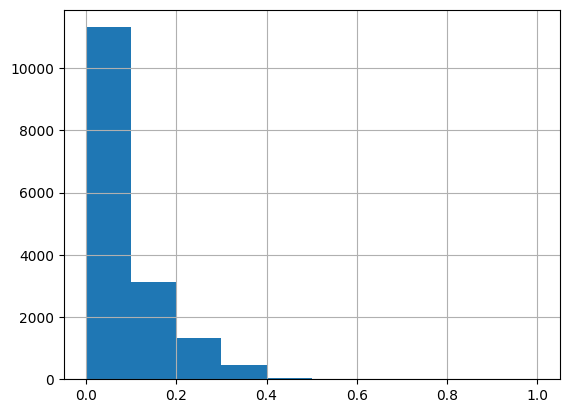

In [9]:
df_val['FaceOcclusion'].hist()

### Check that all images are read correctly

In [7]:
for idx, row in tqdm(df_train.iterrows(), total=len(df_train)):
    try:
        filename = df_train.loc[idx, 'filename']
        img2display = Image.open(f"{image_dir}/{filename}")
    except ValueError as e:
        print(idx, e)
        
for idx, row in tqdm(df_test.iterrows(), total=len(df_test)):
    try:
        filename = df_test.loc[idx, 'filename']
        img2display = Image.open(f"{image_dir}/{filename}")
    except ValueError as e:
        print(idx, e)

100%|██████████| 30507/30507 [03:08<00:00, 161.73it/s]


### Display first images

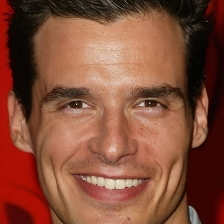

database1/img00015966.jpg 0.015 0.997


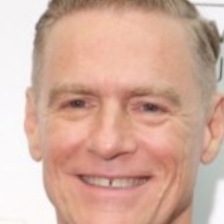

database3/database3/m.01bczm/134-FaceId-0_align.jpg 0.011 0.998


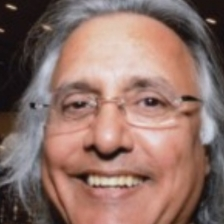

database3/database3/m.01bldq/0-FaceId-0_align.jpg 0.071 0.997


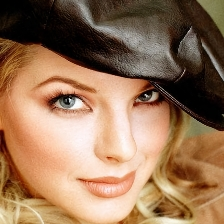

database1/img00017957.jpg 0.351 0.001


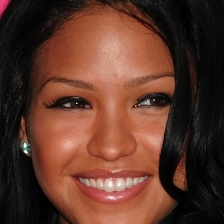

database1/img00020727.jpg 0.128 0.001


In [8]:
for idx, row in df_train[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

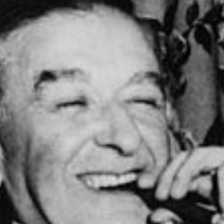

database3/database3/m.01b1jr/84-FaceId-0_align.jpg 0.061 1.0


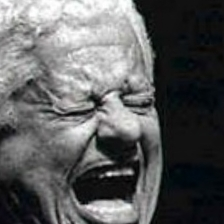

database3/database3/m.018j3w/68-FaceId-0_align.jpg 0.213 0.845


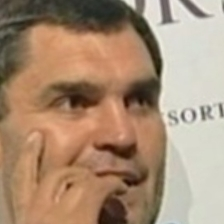

database3/database3/m.01bjs2/47-FaceId-0_align.jpg 0.195 0.999


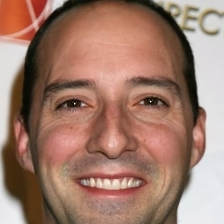

database1/img00010973.jpg 0.015 0.999


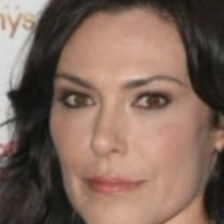

database3/database3/m.01541z/61-FaceId-0_align.jpg 0.108 0.001


In [9]:
for idx, row in df_val[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

### Make Dataset and Dataloader

In [63]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename

In [11]:
training_set = Dataset(df_train, image_dir)
validation_set = Dataset(df_val, image_dir)

params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

### Create naive model

In [13]:
'''
model = torchvision.models.mobilenet_v3_small(num_classes=1)
if torch.cuda.is_available():
    model.cuda()    
model
'''

'\nmodel = torchvision.models.mobilenet_v3_small(num_classes=1)\nif torch.cuda.is_available():\n    model.cuda()    \nmodel\n'

### Loss and optimizer

In [15]:
loss_fn = nn.MSELoss()

### Train naive model

In [12]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

#### Fit on train split

In [56]:
# 定义覆盖率范围
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']


# 统计每个范围的样本数量
df_train['range'] = pd.cut(df_train['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts = df_train['range'].value_counts().sort_index()
print(range_counts)
range_means = df_train.groupby('range')['FaceOcclusion'].mean()
print(range_means)

# 计算权重
total_samples = len(df_train)
# range_weights = {label: (total_samples / count) * (1/30 + mean) for label, count, mean in zip(range_counts.index, range_counts.values, range_means.values)}


range_weights = {label: total_samples / count for label, count in range_counts.items()}
print(range_weights)

range
0-0.025       25700
0.025-0.05    13475
0.05-0.075     8336
0.075-0.1      6612
0.1-0.15      10045
0.15-0.2       6545
0.2-0.25       4255
0.25-0.3       3081
0.3-0.35       1900
>0.35          1124
Name: count, dtype: int64
range
0-0.025       0.011049
0.025-0.05    0.036702
0.05-0.075    0.062360
0.075-0.1     0.087592
0.1-0.15      0.123848
0.15-0.2      0.173653
0.2-0.25      0.223772
0.25-0.3      0.274099
0.3-0.35      0.322642
>0.35         0.395271
Name: FaceOcclusion, dtype: float64
{'0-0.025': 3.1547081712062255, '0.025-0.05': 6.016771799628943, '0.05-0.075': 9.726007677543187, '0.075-0.1': 12.26194797338173, '0.1-0.15': 8.071279243404678, '0.15-0.2': 12.387471352177235, '0.2-0.25': 19.054289071680376, '0.25-0.3': 26.314832846478417, '0.3-0.35': 42.671578947368424, '>0.35': 72.13167259786476}


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1796\1313720282.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  range_means = df_train.groupby('range')['FaceOcclusion'].mean()


In [14]:
# 定义性别权重
gender_counts = df_train['gender'].apply(lambda x: 'male' if x > 0.5 else 'female').value_counts()
total_gender_samples = len(df_train)
gender_weights = {'male': 1, 'female': 1.05}
print(gender_weights)


class WeightedMSELoss2(nn.Module):
    def __init__(self, range_weights, gender_weights):
        super(WeightedMSELoss2, self).__init__()
        self.range_weights = range_weights
        self.gender_weights = gender_weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges, genders):
        loss = self.mse(inputs, targets)
        range_weights = torch.tensor([self.range_weights[str(label)] for label in ranges], device=inputs.device)
        gender_weights = torch.tensor([self.gender_weights['male'] if gender > 0.5 else self.gender_weights['female'] for gender in genders], device=inputs.device)
        total_weights = range_weights * gender_weights
        weighted_loss = loss * total_weights
        return weighted_loss.mean()




{'male': 1, 'female': 1.05}


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# 加载预训练的ResNet模型并修改其最后一层
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 定义自定义损失函数
criterion = WeightedMSELoss2(range_weights, gender_weights)

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        
        # 根据FaceOcclusion值计算range
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges,gender)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10


  0%|          | 4/8134 [00:00<12:33, 10.79it/s]

Batch 0, Loss: 13.895745277404785


 25%|██▍       | 2005/8134 [01:07<03:30, 29.08it/s]

Batch 2000, Loss: 0.02136772871017456


 49%|████▉     | 4006/8134 [02:18<02:22, 28.91it/s]

Batch 4000, Loss: 0.0038590705953538418


 74%|███████▍  | 6004/8134 [03:27<01:11, 29.61it/s]

Batch 6000, Loss: 0.009339768439531326


 98%|█████████▊| 8006/8134 [04:35<00:04, 31.22it/s]

Batch 8000, Loss: 0.023267194628715515


100%|██████████| 8134/8134 [04:40<00:00, 29.04it/s]


Epoch [1/10], Loss: 0.05942357091546228
Epoch 2/10


  0%|          | 4/8134 [00:00<04:26, 30.52it/s]

Batch 0, Loss: 0.017467409372329712


 25%|██▍       | 2003/8134 [01:08<03:20, 30.65it/s]

Batch 2000, Loss: 0.011629866436123848


 49%|████▉     | 4006/8134 [02:16<02:17, 30.07it/s]

Batch 4000, Loss: 0.0016605174168944359


 74%|███████▍  | 6006/8134 [03:24<01:10, 30.18it/s]

Batch 6000, Loss: 0.003041784279048443


 98%|█████████▊| 8006/8134 [04:32<00:04, 27.93it/s]

Batch 8000, Loss: 0.0064949775114655495


100%|██████████| 8134/8134 [04:37<00:00, 29.36it/s]


Epoch [2/10], Loss: 0.015606112176801261
Epoch 3/10


  0%|          | 4/8134 [00:00<04:15, 31.86it/s]

Batch 0, Loss: 0.00817851908504963


 25%|██▍       | 2004/8134 [01:08<04:08, 24.69it/s]

Batch 2000, Loss: 0.013920684345066547


 49%|████▉     | 4006/8134 [02:09<02:03, 33.49it/s]

Batch 4000, Loss: 0.0037084869109094143


 74%|███████▍  | 6006/8134 [03:10<01:06, 32.11it/s]

Batch 6000, Loss: 0.0029347739182412624


 98%|█████████▊| 8006/8134 [04:11<00:04, 30.26it/s]

Batch 8000, Loss: 0.012441234663128853


100%|██████████| 8134/8134 [04:15<00:00, 31.78it/s]


Epoch [3/10], Loss: 0.012446626045585624
Epoch 4/10


  0%|          | 3/8134 [00:00<04:44, 28.60it/s]

Batch 0, Loss: 0.009601959958672523


 25%|██▍       | 2007/8134 [01:02<03:04, 33.13it/s]

Batch 2000, Loss: 0.025433726608753204


 49%|████▉     | 4005/8134 [02:10<02:18, 29.79it/s]

Batch 4000, Loss: 0.02086981013417244


 74%|███████▍  | 6006/8134 [03:20<01:17, 27.34it/s]

Batch 6000, Loss: 0.00617218716070056


 98%|█████████▊| 8006/8134 [04:29<00:04, 29.04it/s]

Batch 8000, Loss: 0.008115662261843681


100%|██████████| 8134/8134 [04:34<00:00, 29.63it/s]


Epoch [4/10], Loss: 0.009625588908695307
Epoch 5/10


  0%|          | 3/8134 [00:00<05:31, 24.51it/s]

Batch 0, Loss: 0.00585415493696928


 25%|██▍       | 2006/8134 [01:13<03:35, 28.41it/s]

Batch 2000, Loss: 0.006268142256885767


 49%|████▉     | 4004/8134 [02:23<02:30, 27.53it/s]

Batch 4000, Loss: 0.003799466183409095


 74%|███████▍  | 6003/8134 [03:35<01:14, 28.51it/s]

Batch 6000, Loss: 0.005351554602384567


 98%|█████████▊| 8004/8134 [04:49<00:04, 29.30it/s]

Batch 8000, Loss: 0.010874265804886818


100%|██████████| 8134/8134 [04:54<00:00, 27.66it/s]


Epoch [5/10], Loss: 0.008146291951897916
Epoch 6/10


  0%|          | 3/8134 [00:00<04:40, 29.03it/s]

Batch 0, Loss: 0.003166540991514921


 25%|██▍       | 2006/8134 [01:10<03:26, 29.72it/s]

Batch 2000, Loss: 0.00039382081013172865


 49%|████▉     | 4006/8134 [02:18<02:18, 29.79it/s]

Batch 4000, Loss: 0.006023496389389038


 74%|███████▍  | 6005/8134 [03:27<01:11, 29.72it/s]

Batch 6000, Loss: 0.016822878271341324


 98%|█████████▊| 8003/8134 [04:39<00:04, 29.36it/s]

Batch 8000, Loss: 0.01882629096508026


100%|██████████| 8134/8134 [04:43<00:00, 28.67it/s]


Epoch [6/10], Loss: 0.007045444279196938
Epoch 7/10


  0%|          | 4/8134 [00:00<04:15, 31.82it/s]

Batch 0, Loss: 0.007529723457992077


 25%|██▍       | 2006/8134 [01:07<03:19, 30.67it/s]

Batch 2000, Loss: 0.004241446033120155


 49%|████▉     | 4006/8134 [02:14<02:16, 30.24it/s]

Batch 4000, Loss: 0.0014946070732548833


 74%|███████▍  | 6004/8134 [03:22<01:08, 31.02it/s]

Batch 6000, Loss: 0.0006181597709655762


 98%|█████████▊| 8006/8134 [04:26<00:04, 29.39it/s]

Batch 8000, Loss: 0.0012716430937871337


100%|██████████| 8134/8134 [04:30<00:00, 30.02it/s]


Epoch [7/10], Loss: 0.005946948330202233
Epoch 8/10


  0%|          | 3/8134 [00:00<04:36, 29.45it/s]

Batch 0, Loss: 0.0012076767161488533


 25%|██▍       | 2005/8134 [01:04<03:24, 30.03it/s]

Batch 2000, Loss: 0.0018257565097883344


 49%|████▉     | 4004/8134 [02:09<02:17, 30.07it/s]

Batch 4000, Loss: 0.0022526318207383156


 74%|███████▍  | 6004/8134 [03:14<01:09, 30.60it/s]

Batch 6000, Loss: 0.0017773464787751436


 98%|█████████▊| 8006/8134 [04:18<00:04, 30.93it/s]

Batch 8000, Loss: 0.0006440720753744245


100%|██████████| 8134/8134 [04:23<00:00, 30.92it/s]


Epoch [8/10], Loss: 0.005183127787493042
Epoch 9/10


  0%|          | 3/8134 [00:00<05:01, 26.97it/s]

Batch 0, Loss: 0.005574076436460018


 25%|██▍       | 2006/8134 [01:05<03:17, 30.98it/s]

Batch 2000, Loss: 0.004786142148077488


 49%|████▉     | 4007/8134 [02:09<02:12, 31.22it/s]

Batch 4000, Loss: 0.006045527756214142


 74%|███████▍  | 6003/8134 [03:14<01:08, 31.13it/s]

Batch 6000, Loss: 0.0018959060544148088


 98%|█████████▊| 8004/8134 [04:18<00:04, 30.83it/s]

Batch 8000, Loss: 0.0023411016445606947


100%|██████████| 8134/8134 [04:22<00:00, 30.93it/s]


Epoch [9/10], Loss: 0.004500613061816158
Epoch 10/10


  0%|          | 3/8134 [00:00<04:40, 28.98it/s]

Batch 0, Loss: 0.012911796569824219


 25%|██▍       | 2005/8134 [01:05<03:21, 30.48it/s]

Batch 2000, Loss: 0.001366334967315197


 49%|████▉     | 4006/8134 [02:10<02:13, 30.94it/s]

Batch 4000, Loss: 0.0034672669135034084


 74%|███████▍  | 6006/8134 [03:14<01:10, 30.07it/s]

Batch 6000, Loss: 0.000755969958845526


 98%|█████████▊| 8005/8134 [04:19<00:04, 30.51it/s]

Batch 8000, Loss: 0.031960491091012955


100%|██████████| 8134/8134 [04:23<00:00, 30.82it/s]

Epoch [10/10], Loss: 0.004021291168562584
Training complete


In [39]:
#  drop out
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# 加载预训练的ResNet模型并修改其最后一层
model = models.resnet18(pretrained=True)

# 修改最后一层为回归层，并添加 Dropout
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # 添加 Dropout 层，概率为 0.5
    nn.Linear(model.fc.in_features, 1)
)

model = model.to(device)

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=1e-4)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()
    
# 定义自定义损失函数
criterion = WeightedMSELoss(range_weights)

num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        
        # 根据FaceOcclusion值计算range
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


  0%|          | 4/8134 [00:00<12:10, 11.13it/s]

Batch 0, Loss: 15.267549514770508


 25%|██▍       | 2004/8134 [01:02<03:17, 30.96it/s]

Batch 2000, Loss: 0.42806276679039


 49%|████▉     | 4006/8134 [02:08<02:12, 31.08it/s]

Batch 4000, Loss: 0.25640085339546204


 74%|███████▍  | 6005/8134 [03:13<01:12, 29.53it/s]

Batch 6000, Loss: 0.05989650636911392


 98%|█████████▊| 8004/8134 [04:18<00:04, 29.54it/s]

Batch 8000, Loss: 0.05621059983968735


100%|██████████| 8134/8134 [04:22<00:00, 30.93it/s]


Epoch [1/20], Loss: 0.42840806654362645
Epoch 2/20


  0%|          | 4/8134 [00:00<04:09, 32.56it/s]

Batch 0, Loss: 0.01868419349193573


 25%|██▍       | 2006/8134 [01:05<03:16, 31.18it/s]

Batch 2000, Loss: 0.015036902390420437


 49%|████▉     | 4005/8134 [02:09<02:18, 29.81it/s]

Batch 4000, Loss: 0.008262800052762032


 74%|███████▍  | 6004/8134 [03:14<01:09, 30.80it/s]

Batch 6000, Loss: 0.0041946046985685825


 98%|█████████▊| 8003/8134 [04:19<00:04, 29.92it/s]

Batch 8000, Loss: 0.019365474581718445


100%|██████████| 8134/8134 [04:23<00:00, 30.84it/s]


Epoch [2/20], Loss: 0.021690598195735874
Epoch 3/20


  0%|          | 3/8134 [00:00<04:59, 27.15it/s]

Batch 0, Loss: 0.00967356190085411


 25%|██▍       | 2005/8134 [01:06<03:27, 29.60it/s]

Batch 2000, Loss: 0.0042714145965874195


 49%|████▉     | 4004/8134 [02:14<02:12, 31.14it/s]

Batch 4000, Loss: 0.007352720946073532


 74%|███████▍  | 6006/8134 [03:20<01:07, 31.75it/s]

Batch 6000, Loss: 0.005717090796679258


 98%|█████████▊| 8006/8134 [04:26<00:04, 31.83it/s]

Batch 8000, Loss: 0.005611411761492491


100%|██████████| 8134/8134 [04:30<00:00, 30.09it/s]


Epoch [3/20], Loss: 0.01578387569517945
Epoch 4/20


  0%|          | 3/8134 [00:00<05:01, 26.93it/s]

Batch 0, Loss: 0.004084839019924402


 25%|██▍       | 2007/8134 [01:04<03:20, 30.55it/s]

Batch 2000, Loss: 0.01618725061416626


 49%|████▉     | 4007/8134 [02:09<02:11, 31.46it/s]

Batch 4000, Loss: 0.028187762945890427


 74%|███████▍  | 6007/8134 [03:14<01:08, 31.20it/s]

Batch 6000, Loss: 0.019871985539793968


 98%|█████████▊| 8004/8134 [04:18<00:03, 34.42it/s]

Batch 8000, Loss: 0.009454959072172642


100%|██████████| 8134/8134 [04:22<00:00, 31.01it/s]


Epoch [4/20], Loss: 0.013138551468398929
Epoch 5/20


  0%|          | 4/8134 [00:00<03:58, 34.10it/s]

Batch 0, Loss: 0.022172274067997932


 25%|██▍       | 2004/8134 [00:58<02:59, 34.18it/s]

Batch 2000, Loss: 0.004855080973356962


 49%|████▉     | 4004/8134 [01:58<02:02, 33.59it/s]

Batch 4000, Loss: 0.021481094881892204


 74%|███████▍  | 6004/8134 [02:57<01:02, 33.95it/s]

Batch 6000, Loss: 0.003280205652117729


 98%|█████████▊| 8004/8134 [03:57<00:03, 34.52it/s]

Batch 8000, Loss: 0.0026057790964841843


100%|██████████| 8134/8134 [04:01<00:00, 33.74it/s]


Epoch [5/20], Loss: 0.011273464684408608
Epoch 6/20


  0%|          | 4/8134 [00:00<03:58, 34.08it/s]

Batch 0, Loss: 0.00292032933793962


 25%|██▍       | 2004/8134 [00:58<02:58, 34.25it/s]

Batch 2000, Loss: 0.012506358325481415


 49%|████▉     | 4004/8134 [01:58<02:02, 33.68it/s]

Batch 4000, Loss: 0.004851578734815121


 74%|███████▍  | 6004/8134 [02:57<01:02, 33.88it/s]

Batch 6000, Loss: 0.018865851685404778


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.41it/s]

Batch 8000, Loss: 0.010352060198783875


100%|██████████| 8134/8134 [04:00<00:00, 33.80it/s]


Epoch [6/20], Loss: 0.010064232911010945
Epoch 7/20


  0%|          | 4/8134 [00:00<03:59, 33.90it/s]

Batch 0, Loss: 0.004892949014902115


 25%|██▍       | 2004/8134 [00:58<03:00, 33.88it/s]

Batch 2000, Loss: 0.010518033988773823


 49%|████▉     | 4004/8134 [01:58<02:02, 33.70it/s]

Batch 4000, Loss: 0.0027951321098953485


 74%|███████▍  | 6004/8134 [02:57<01:03, 33.62it/s]

Batch 6000, Loss: 0.02301129512488842


 98%|█████████▊| 8006/8134 [03:57<00:03, 34.17it/s]

Batch 8000, Loss: 0.008728132583200932


100%|██████████| 8134/8134 [04:00<00:00, 33.76it/s]


Epoch [7/20], Loss: 0.008977919056965118
Epoch 8/20


  0%|          | 4/8134 [00:00<04:00, 33.78it/s]

Batch 0, Loss: 0.022113069891929626


 25%|██▍       | 2004/8134 [00:58<02:59, 34.21it/s]

Batch 2000, Loss: 0.008798264898359776


 49%|████▉     | 4004/8134 [01:58<02:03, 33.47it/s]

Batch 4000, Loss: 0.06013529747724533


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.18it/s]

Batch 6000, Loss: 0.0032645189203321934


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.30it/s]

Batch 8000, Loss: 0.009555799886584282


100%|██████████| 8134/8134 [04:00<00:00, 33.82it/s]


Epoch [8/20], Loss: 0.008002885207963094
Epoch 9/20


  0%|          | 4/8134 [00:00<03:56, 34.44it/s]

Batch 0, Loss: 0.002787854289636016


 25%|██▍       | 2004/8134 [00:58<02:59, 34.22it/s]

Batch 2000, Loss: 0.002888432703912258


 49%|████▉     | 4004/8134 [01:58<02:02, 33.71it/s]

Batch 4000, Loss: 0.003753554541617632


 74%|███████▍  | 6004/8134 [02:57<01:03, 33.58it/s]

Batch 6000, Loss: 0.0010205958969891071


 98%|█████████▊| 8004/8134 [03:56<00:03, 33.98it/s]

Batch 8000, Loss: 0.0036240178160369396


100%|██████████| 8134/8134 [04:00<00:00, 33.79it/s]


Epoch [9/20], Loss: 0.006929047087420316
Epoch 10/20


  0%|          | 4/8134 [00:00<04:02, 33.52it/s]

Batch 0, Loss: 0.005915378220379353


 25%|██▍       | 2004/8134 [00:58<02:58, 34.25it/s]

Batch 2000, Loss: 0.009877221658825874


 49%|████▉     | 4004/8134 [01:58<02:02, 33.68it/s]

Batch 4000, Loss: 0.001173321157693863


 74%|███████▍  | 6004/8134 [02:57<01:03, 33.53it/s]

Batch 6000, Loss: 0.004705245140939951


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.25it/s]

Batch 8000, Loss: 0.005396649241447449


100%|██████████| 8134/8134 [04:00<00:00, 33.81it/s]


Epoch [10/20], Loss: 0.006534409088759205
Epoch 11/20


  0%|          | 4/8134 [00:00<04:01, 33.71it/s]

Batch 0, Loss: 0.004780503921210766


 25%|██▍       | 2004/8134 [00:58<03:00, 34.04it/s]

Batch 2000, Loss: 0.025105591863393784


 49%|████▉     | 4004/8134 [01:58<02:03, 33.33it/s]

Batch 4000, Loss: 0.005131879821419716


 74%|███████▍  | 6004/8134 [02:57<01:03, 33.73it/s]

Batch 6000, Loss: 0.0017253521364182234


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.46it/s]

Batch 8000, Loss: 0.001838391530327499


100%|██████████| 8134/8134 [04:00<00:00, 33.80it/s]


Epoch [11/20], Loss: 0.005793640040017878
Epoch 12/20


  0%|          | 4/8134 [00:00<03:56, 34.30it/s]

Batch 0, Loss: 0.002577665727585554


 25%|██▍       | 2004/8134 [00:58<02:59, 34.17it/s]

Batch 2000, Loss: 0.007277908269315958


 49%|████▉     | 4004/8134 [01:58<02:03, 33.44it/s]

Batch 4000, Loss: 0.0012244642712175846


 74%|███████▍  | 6004/8134 [02:57<01:02, 33.81it/s]

Batch 6000, Loss: 0.0017833533929660916


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.45it/s]

Batch 8000, Loss: 0.0012638811022043228


100%|██████████| 8134/8134 [04:00<00:00, 33.82it/s]


Epoch [12/20], Loss: 0.005284388310115911
Epoch 13/20


  0%|          | 4/8134 [00:00<04:07, 32.83it/s]

Batch 0, Loss: 0.012854410335421562


 25%|██▍       | 2004/8134 [00:58<02:59, 34.10it/s]

Batch 2000, Loss: 0.0015813233330845833


 49%|████▉     | 4004/8134 [01:58<02:03, 33.42it/s]

Batch 4000, Loss: 0.0001751612580846995


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.19it/s]

Batch 6000, Loss: 0.0034577748738229275


 98%|█████████▊| 8004/8134 [03:56<00:03, 32.71it/s]

Batch 8000, Loss: 0.011318592354655266


100%|██████████| 8134/8134 [04:00<00:00, 33.79it/s]


Epoch [13/20], Loss: 0.005022394601663302
Epoch 14/20


  0%|          | 4/8134 [00:00<04:00, 33.75it/s]

Batch 0, Loss: 0.0014130474301055074


 25%|██▍       | 2004/8134 [00:58<03:00, 33.94it/s]

Batch 2000, Loss: 0.002498292364180088


 49%|████▉     | 4004/8134 [01:58<02:06, 32.68it/s]

Batch 4000, Loss: 0.0029757351148873568


 74%|███████▍  | 6004/8134 [02:58<01:03, 33.75it/s]

Batch 6000, Loss: 0.003691788762807846


 98%|█████████▊| 8004/8134 [03:57<00:03, 34.14it/s]

Batch 8000, Loss: 0.006621856242418289


100%|██████████| 8134/8134 [04:01<00:00, 33.74it/s]


Epoch [14/20], Loss: 0.004550673794541125
Epoch 15/20


  0%|          | 4/8134 [00:00<04:05, 33.05it/s]

Batch 0, Loss: 0.002635990036651492


 25%|██▍       | 2004/8134 [00:58<02:59, 34.14it/s]

Batch 2000, Loss: 0.0029074533376842737


 49%|████▉     | 4004/8134 [01:58<02:02, 33.59it/s]

Batch 4000, Loss: 0.009413843974471092


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.23it/s]

Batch 6000, Loss: 0.0005970244528725743


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.36it/s]

Batch 8000, Loss: 0.0018280200893059373


100%|██████████| 8134/8134 [04:00<00:00, 33.81it/s]


Epoch [15/20], Loss: 0.004054113596520475
Epoch 16/20


  0%|          | 4/8134 [00:00<03:58, 34.15it/s]

Batch 0, Loss: 0.006578168831765652


 25%|██▍       | 2004/8134 [00:58<02:58, 34.29it/s]

Batch 2000, Loss: 0.004432089626789093


 49%|████▉     | 4004/8134 [01:58<02:03, 33.42it/s]

Batch 4000, Loss: 0.003263872815296054


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.09it/s]

Batch 6000, Loss: 0.0037871715612709522


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.16it/s]

Batch 8000, Loss: 0.0014822824159637094


100%|██████████| 8134/8134 [04:00<00:00, 33.82it/s]


Epoch [16/20], Loss: 0.0036786203612555126
Epoch 17/20


  0%|          | 4/8134 [00:00<04:06, 32.98it/s]

Batch 0, Loss: 0.0023309867829084396


 25%|██▍       | 2004/8134 [00:58<03:00, 34.05it/s]

Batch 2000, Loss: 0.001029598293825984


 49%|████▉     | 4004/8134 [01:58<02:02, 33.60it/s]

Batch 4000, Loss: 0.0002936279051937163


 74%|███████▍  | 6004/8134 [02:58<01:03, 33.47it/s]

Batch 6000, Loss: 0.020739372819662094


 98%|█████████▊| 8004/8134 [03:57<00:03, 34.03it/s]

Batch 8000, Loss: 0.0012428967747837305


100%|██████████| 8134/8134 [04:01<00:00, 33.73it/s]


Epoch [17/20], Loss: 0.003611133917420102
Epoch 18/20


  0%|          | 4/8134 [00:00<04:03, 33.33it/s]

Batch 0, Loss: 0.0019305262248963118


 25%|██▍       | 2004/8134 [00:59<03:00, 33.90it/s]

Batch 2000, Loss: 0.004420418757945299


 49%|████▉     | 4004/8134 [01:58<02:04, 33.12it/s]

Batch 4000, Loss: 0.002078540623188019


 74%|███████▍  | 6004/8134 [02:58<01:03, 33.68it/s]

Batch 6000, Loss: 0.00039543042657896876


 98%|█████████▊| 8004/8134 [03:57<00:03, 33.92it/s]

Batch 8000, Loss: 0.0005526941968128085


100%|██████████| 8134/8134 [04:01<00:00, 33.65it/s]


Epoch [18/20], Loss: 0.0031179286827419175
Epoch 19/20


  0%|          | 4/8134 [00:00<04:00, 33.85it/s]

Batch 0, Loss: 0.0016916845925152302


 25%|██▍       | 2004/8134 [00:59<02:58, 34.25it/s]

Batch 2000, Loss: 0.000946396088693291


 49%|████▉     | 4004/8134 [01:58<02:02, 33.68it/s]

Batch 4000, Loss: 0.0007213230710476637


 74%|███████▍  | 6004/8134 [02:58<01:03, 33.65it/s]

Batch 6000, Loss: 0.002294881734997034


 98%|█████████▊| 8004/8134 [03:57<00:03, 34.12it/s]

Batch 8000, Loss: 0.000780145637691021


100%|██████████| 8134/8134 [04:01<00:00, 33.71it/s]


Epoch [19/20], Loss: 0.003019244676825761
Epoch 20/20


  0%|          | 4/8134 [00:00<03:59, 33.97it/s]

Batch 0, Loss: 0.004671720787882805


 25%|██▍       | 2004/8134 [00:58<02:59, 34.23it/s]

Batch 2000, Loss: 0.018216747790575027


 49%|████▉     | 4004/8134 [01:58<02:12, 31.20it/s]

Batch 4000, Loss: 0.0015973813133314252


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.02it/s]

Batch 6000, Loss: 0.002447527600452304


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.24it/s]

Batch 8000, Loss: 0.000471621984615922


100%|██████████| 8134/8134 [04:00<00:00, 33.82it/s]

Epoch [20/20], Loss: 0.0029681516054291747
Training complete


In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Load pre-trained ResNet and modify it
# Load pre-trained ResNet and modify it for regression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()
    
    
# Define loss and optimizer
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y,range_weights)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


'''


# 加载预训练的EfficientNet
model = models.efficientnet_b0(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
# 修改最后的全连接层
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')
'''

Epoch 1/20


  0%|          | 3/8134 [00:00<16:28,  8.23it/s]

Batch 0, Loss: 2.122220039367676


 25%|██▍       | 2005/8134 [01:00<02:58, 34.27it/s]

Batch 2000, Loss: 0.05808461830019951


 49%|████▉     | 4005/8134 [01:58<02:01, 33.85it/s]

Batch 4000, Loss: 0.00809390377253294


 74%|███████▍  | 6005/8134 [02:57<01:02, 34.11it/s]

Batch 6000, Loss: 0.01588238775730133


 98%|█████████▊| 8005/8134 [03:56<00:03, 34.19it/s]

Batch 8000, Loss: 0.01930374465882778


100%|██████████| 8134/8134 [04:00<00:00, 33.88it/s]


Epoch [1/20], Loss: 0.11717633192115966
Epoch 2/20


  0%|          | 4/8134 [00:00<03:59, 33.96it/s]

Batch 0, Loss: 0.021580493077635765


 25%|██▍       | 2004/8134 [00:58<02:58, 34.28it/s]

Batch 2000, Loss: 0.022178633138537407


 49%|████▉     | 4004/8134 [01:56<02:01, 33.89it/s]

Batch 4000, Loss: 0.015210089273750782


 74%|███████▍  | 6004/8134 [02:55<01:02, 34.03it/s]

Batch 6000, Loss: 0.004914631601423025


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.21it/s]

Batch 8000, Loss: 0.00762940663844347


100%|██████████| 8134/8134 [03:57<00:00, 34.20it/s]


Epoch [2/20], Loss: 0.03147274959603692
Epoch 3/20


  0%|          | 4/8134 [00:00<04:02, 33.46it/s]

Batch 0, Loss: 0.013120305724442005


 25%|██▍       | 2004/8134 [00:58<02:58, 34.41it/s]

Batch 2000, Loss: 0.0056054554879665375


 49%|████▉     | 4004/8134 [01:56<02:02, 33.72it/s]

Batch 4000, Loss: 0.03431906923651695


 74%|███████▍  | 6004/8134 [02:55<01:02, 34.08it/s]

Batch 6000, Loss: 0.06003047153353691


 98%|█████████▊| 8008/8134 [03:54<00:03, 34.41it/s]

Batch 8000, Loss: 0.0424320362508297


100%|██████████| 8134/8134 [03:57<00:00, 34.21it/s]


Epoch [3/20], Loss: 0.023690225959531123
Epoch 4/20


  0%|          | 4/8134 [00:00<03:58, 34.13it/s]

Batch 0, Loss: 0.0012769632739946246


 25%|██▍       | 2004/8134 [00:58<02:57, 34.45it/s]

Batch 2000, Loss: 0.01937342993915081


 49%|████▉     | 4004/8134 [01:56<02:02, 33.78it/s]

Batch 4000, Loss: 0.020457426086068153


 74%|███████▍  | 6004/8134 [02:55<01:02, 34.01it/s]

Batch 6000, Loss: 0.006627996452152729


 98%|█████████▊| 8004/8134 [03:53<00:03, 34.19it/s]

Batch 8000, Loss: 0.0046372911892831326


100%|██████████| 8134/8134 [03:57<00:00, 34.22it/s]


Epoch [4/20], Loss: 0.018840962984832576
Epoch 5/20


  0%|          | 4/8134 [00:00<04:06, 32.97it/s]

Batch 0, Loss: 0.0022606870625168085


 25%|██▍       | 2004/8134 [00:58<02:57, 34.53it/s]

Batch 2000, Loss: 0.00775667279958725


 49%|████▉     | 4004/8134 [01:56<02:02, 33.76it/s]

Batch 4000, Loss: 0.006277673877775669


 74%|███████▍  | 6004/8134 [02:55<01:02, 33.93it/s]

Batch 6000, Loss: 0.0043052444234490395


 98%|█████████▊| 8008/8134 [03:53<00:03, 34.35it/s]

Batch 8000, Loss: 0.01720513217151165


100%|██████████| 8134/8134 [03:57<00:00, 34.23it/s]


Epoch [5/20], Loss: 0.01518881737954297
Epoch 6/20


  0%|          | 4/8134 [00:00<03:56, 34.43it/s]

Batch 0, Loss: 0.02693110518157482


 25%|██▍       | 2004/8134 [00:58<02:58, 34.31it/s]

Batch 2000, Loss: 0.0037754811346530914


 49%|████▉     | 4004/8134 [01:56<01:59, 34.51it/s]

Batch 4000, Loss: 0.021566791459918022


 74%|███████▍  | 6004/8134 [02:55<01:02, 34.07it/s]

Batch 6000, Loss: 0.008901314809918404


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.63it/s]

Batch 8000, Loss: 0.0075028822757303715


100%|██████████| 8134/8134 [03:57<00:00, 34.21it/s]


Epoch [6/20], Loss: 0.012798366815074801
Epoch 7/20


  0%|          | 4/8134 [00:00<03:55, 34.59it/s]

Batch 0, Loss: 0.009149983525276184


 25%|██▍       | 2004/8134 [00:58<02:56, 34.64it/s]

Batch 2000, Loss: 0.0007083608652465045


 49%|████▉     | 4004/8134 [01:56<01:58, 34.84it/s]

Batch 4000, Loss: 0.009247890673577785


 74%|███████▍  | 6004/8134 [02:55<01:02, 34.04it/s]

Batch 6000, Loss: 0.0012981494655832648


 98%|█████████▊| 8004/8134 [03:53<00:03, 34.59it/s]

Batch 8000, Loss: 0.011075588874518871


100%|██████████| 8134/8134 [03:57<00:00, 34.22it/s]


Epoch [7/20], Loss: 0.010633694812341181
Epoch 8/20


  0%|          | 4/8134 [00:00<03:57, 34.23it/s]

Batch 0, Loss: 0.007489469833672047


 25%|██▍       | 2004/8134 [00:58<02:57, 34.51it/s]

Batch 2000, Loss: 0.0027741920202970505


 49%|████▉     | 4004/8134 [01:56<02:01, 33.89it/s]

Batch 4000, Loss: 0.003612442407757044


 74%|███████▍  | 6004/8134 [02:55<01:02, 33.95it/s]

Batch 6000, Loss: 0.009434307925403118


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.54it/s]

Batch 8000, Loss: 0.003780233906581998


100%|██████████| 8134/8134 [03:57<00:00, 34.19it/s]


Epoch [8/20], Loss: 0.0096688524969548
Epoch 9/20


  0%|          | 4/8134 [00:00<03:56, 34.33it/s]

Batch 0, Loss: 0.0057408190332353115


 25%|██▍       | 2004/8134 [00:58<02:56, 34.65it/s]

Batch 2000, Loss: 0.007143368013203144


 49%|████▉     | 4004/8134 [01:56<02:00, 34.35it/s]

Batch 4000, Loss: 0.011038071475923061


 74%|███████▍  | 6004/8134 [02:55<01:03, 33.80it/s]

Batch 6000, Loss: 0.0042536319233477116


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.59it/s]

Batch 8000, Loss: 0.08243505656719208


100%|██████████| 8134/8134 [03:58<00:00, 34.17it/s]


Epoch [9/20], Loss: 0.0078012350916816745
Epoch 10/20


  0%|          | 4/8134 [00:00<03:58, 34.10it/s]

Batch 0, Loss: 0.016238022595643997


 25%|██▍       | 2004/8134 [00:58<02:56, 34.65it/s]

Batch 2000, Loss: 0.00934914406388998


 49%|████▉     | 4004/8134 [01:56<01:59, 34.59it/s]

Batch 4000, Loss: 0.004921067506074905


 74%|███████▍  | 6004/8134 [02:55<01:02, 33.87it/s]

Batch 6000, Loss: 0.007638399489223957


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.80it/s]

Batch 8000, Loss: 0.002442528260871768


100%|██████████| 8134/8134 [03:57<00:00, 34.19it/s]


Epoch [10/20], Loss: 0.007324898799482301
Epoch 11/20


  0%|          | 4/8134 [00:00<04:00, 33.78it/s]

Batch 0, Loss: 0.001954353181645274


 25%|██▍       | 2004/8134 [00:58<02:55, 34.84it/s]

Batch 2000, Loss: 0.003982309717684984


 49%|████▉     | 4004/8134 [01:56<02:01, 34.09it/s]

Batch 4000, Loss: 0.00584635091945529


 74%|███████▍  | 6004/8134 [02:55<01:02, 34.03it/s]

Batch 6000, Loss: 0.002301979809999466


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.14it/s]

Batch 8000, Loss: 0.0015434703091159463


100%|██████████| 8134/8134 [03:57<00:00, 34.20it/s]


Epoch [11/20], Loss: 0.006472372668295506
Epoch 12/20


  0%|          | 4/8134 [00:00<03:55, 34.48it/s]

Batch 0, Loss: 0.0017208487261086702


 25%|██▍       | 2004/8134 [00:58<02:57, 34.46it/s]

Batch 2000, Loss: 0.0022332733497023582


 49%|████▉     | 4004/8134 [01:56<01:59, 34.52it/s]

Batch 4000, Loss: 0.0020873078610748053


 74%|███████▍  | 6004/8134 [02:55<01:02, 34.03it/s]

Batch 6000, Loss: 0.007766357157379389


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.40it/s]

Batch 8000, Loss: 0.006316309329122305


100%|██████████| 8134/8134 [03:58<00:00, 34.17it/s]


Epoch [12/20], Loss: 0.005835921395306724
Epoch 13/20


  0%|          | 4/8134 [00:00<03:56, 34.38it/s]

Batch 0, Loss: 0.0010930728167295456


 25%|██▍       | 2004/8134 [00:58<02:57, 34.60it/s]

Batch 2000, Loss: 0.002498380374163389


 49%|████▉     | 4004/8134 [01:56<02:00, 34.36it/s]

Batch 4000, Loss: 0.012318347580730915


 74%|███████▍  | 6004/8134 [02:55<01:02, 33.83it/s]

Batch 6000, Loss: 0.0014311351114884019


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.14it/s]

Batch 8000, Loss: 0.008791855536401272


100%|██████████| 8134/8134 [03:58<00:00, 34.14it/s]


Epoch [13/20], Loss: 0.005056894893242631
Epoch 14/20


  0%|          | 4/8134 [00:00<03:58, 34.15it/s]

Batch 0, Loss: 0.0025840469170361757


 25%|██▍       | 2004/8134 [00:58<02:58, 34.37it/s]

Batch 2000, Loss: 0.020136896520853043


 49%|████▉     | 4004/8134 [01:56<01:59, 34.48it/s]

Batch 4000, Loss: 0.0033400908578187227


 74%|███████▍  | 6004/8134 [02:55<01:02, 33.88it/s]

Batch 6000, Loss: 0.01041710190474987


 98%|█████████▊| 8004/8134 [03:55<00:03, 33.91it/s]

Batch 8000, Loss: 0.030487164855003357


100%|██████████| 8134/8134 [03:59<00:00, 34.03it/s]


Epoch [14/20], Loss: 0.004744368631556184
Epoch 15/20


  0%|          | 4/8134 [00:00<03:59, 34.00it/s]

Batch 0, Loss: 0.003435242222622037


 25%|██▍       | 2004/8134 [00:58<02:57, 34.51it/s]

Batch 2000, Loss: 0.02159610390663147


 49%|████▉     | 4004/8134 [01:56<02:00, 34.41it/s]

Batch 4000, Loss: 0.001554462593048811


 74%|███████▍  | 6004/8134 [02:55<01:03, 33.73it/s]

Batch 6000, Loss: 0.002456632675603032


 98%|█████████▊| 8004/8134 [03:55<00:03, 33.98it/s]

Batch 8000, Loss: 0.003945167176425457


100%|██████████| 8134/8134 [03:59<00:00, 34.03it/s]


Epoch [15/20], Loss: 0.004366457621032935
Epoch 16/20


  0%|          | 4/8134 [00:00<03:58, 34.10it/s]

Batch 0, Loss: 0.002565898699685931


 25%|██▍       | 2008/8134 [00:58<02:57, 34.56it/s]

Batch 2000, Loss: 0.0022321424912661314


 49%|████▉     | 4004/8134 [01:57<02:00, 34.16it/s]

Batch 4000, Loss: 0.006052849348634481


 74%|███████▍  | 6004/8134 [02:55<01:02, 33.92it/s]

Batch 6000, Loss: 0.003879681695252657


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.28it/s]

Batch 8000, Loss: 0.0041900030337274075


100%|██████████| 8134/8134 [03:58<00:00, 34.10it/s]


Epoch [16/20], Loss: 0.003983656706343616
Epoch 17/20


  0%|          | 4/8134 [00:00<03:55, 34.49it/s]

Batch 0, Loss: 0.004207079764455557


 25%|██▍       | 2004/8134 [00:58<02:57, 34.60it/s]

Batch 2000, Loss: 0.001553333131596446


 49%|████▉     | 4004/8134 [01:56<02:01, 34.10it/s]

Batch 4000, Loss: 0.002596998354420066


 74%|███████▍  | 6004/8134 [02:55<01:02, 34.13it/s]

Batch 6000, Loss: 0.005331028252840042


 98%|█████████▊| 8004/8134 [03:54<00:03, 34.40it/s]

Batch 8000, Loss: 0.005635493900626898


100%|██████████| 8134/8134 [03:58<00:00, 34.15it/s]


Epoch [17/20], Loss: 0.003732866235282045
Epoch 18/20


  0%|          | 4/8134 [00:00<03:59, 33.97it/s]

Batch 0, Loss: 0.005654157139360905


 25%|██▍       | 2004/8134 [00:58<02:58, 34.41it/s]

Batch 2000, Loss: 0.004342011641710997


 49%|████▉     | 4004/8134 [01:56<01:59, 34.45it/s]

Batch 4000, Loss: 0.002715534530580044


 74%|███████▍  | 6004/8134 [02:55<01:03, 33.50it/s]

Batch 6000, Loss: 0.0009815575322136283


 98%|█████████▊| 8004/8134 [03:54<00:03, 33.98it/s]

Batch 8000, Loss: 0.0032853931188583374


100%|██████████| 8134/8134 [03:58<00:00, 34.17it/s]


Epoch [18/20], Loss: 0.0035356156647603004
Epoch 19/20


  0%|          | 3/8134 [00:00<04:48, 28.17it/s]

Batch 0, Loss: 0.00343745737336576


 25%|██▍       | 2003/8134 [00:58<02:58, 34.34it/s]

Batch 2000, Loss: 0.0011817043414339423


 49%|████▉     | 4003/8134 [01:56<02:00, 34.20it/s]

Batch 4000, Loss: 0.0031981964129954576


 74%|███████▍  | 6003/8134 [02:55<01:02, 34.10it/s]

Batch 6000, Loss: 0.004492965992540121


 98%|█████████▊| 8007/8134 [03:54<00:03, 33.80it/s]

Batch 8000, Loss: 0.00371973286382854


100%|██████████| 8134/8134 [03:58<00:00, 34.17it/s]


Epoch [19/20], Loss: 0.0032455689395605317
Epoch 20/20


  0%|          | 4/8134 [00:00<04:01, 33.69it/s]

Batch 0, Loss: 0.0018231895519420505


 25%|██▍       | 2004/8134 [00:58<02:57, 34.60it/s]

Batch 2000, Loss: 0.0009558608871884644


 49%|████▉     | 4004/8134 [01:56<01:59, 34.61it/s]

Batch 4000, Loss: 0.0023315742146223783


 74%|███████▍  | 6004/8134 [02:55<01:01, 34.37it/s]

Batch 6000, Loss: 0.0013964511454105377


 98%|█████████▊| 8004/8134 [03:54<00:03, 33.79it/s]

Batch 8000, Loss: 0.003126116469502449


100%|██████████| 8134/8134 [03:57<00:00, 34.19it/s]

Epoch [20/20], Loss: 0.0030555304726145862
Training complete


'\n\n\n# 加载预训练的EfficientNet\nmodel = models.efficientnet_b0(pretrained=True)\nif torch.cuda.is_available():\n    model.cuda()\n    \n# 修改最后的全连接层\nnum_features = model.classifier[1].in_features\nmodel.classifier[1] = nn.Linear(num_features, 1)\n\n# 将模型移动到GPU\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = model.to(device)\n\n# 定义损失函数和优化器\ncriterion = nn.MSELoss()\noptimizer = optim.Adam(model.parameters(), lr=1e-4)\n\n\nnum_epochs = 10\nfor epoch in range(num_epochs):\n    print(f"Epoch {epoch+1}/{num_epochs}")\n    model.train()\n    running_loss = 0.0\n    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):\n        X, y = X.to(device), y.to(device).view(-1, 1)\n        optimizer.zero_grad()\n        y_pred = model(X)\n        loss = criterion(y_pred, y)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n\n        if batch_idx % 2000 == 0:\n            print

In [18]:
'''
num_epochs = 5

for n in range(num_epochs):
    print(f"Epoch {n}")
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        # Transfer to GPU
        X, y = X.to(device), y.to(device)
        y = torch.reshape(y, (len(y), 1))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if loss.isnan():
            print(filename)
            print('label', y)
            print('y_pred', y_pred)
            break

        if batch_idx % 200 == 0:
            print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
'''

Epoch 0


  0%|          | 0/10168 [00:00<?, ?it/s]

  0%|          | 0/10168 [00:00<?, ?it/s]


NameError: name 'model' is not defined

### 2 model black and white / color

In [74]:

from PIL import Image
import numpy as np
def is_grayscale(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    if np.array_equal(img_np[..., 0], img_np[..., 1]) and np.array_equal(img_np[..., 0], img_np[..., 2]):
        return True
    return False

# 使用该函数划分数据集
df_train['is_grayscale'] = df_train['filename'].apply(lambda x: is_grayscale(f"{image_dir}/{x}"))

# 划分数据集
df_train_grayscale = df_train[df_train['is_grayscale']]
df_train_color = df_train[~df_train['is_grayscale']]

# 移除临时的is_grayscale列
df_train_grayscale.drop(columns=['is_grayscale'], inplace=True)
df_train_color.drop(columns=['is_grayscale'], inplace=True)





Grayscale images count: 11191
Color images count: 69885


C:\Users\ASUS\AppData\Local\Temp\ipykernel_1796\3125411470.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_grayscale.drop(columns=['is_grayscale'], inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1796\3125411470.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_color.drop(columns=['is_grayscale'], inplace=True)


In [109]:
# 检查划分后的数据集
print("Grayscale images count:", len(df_train_grayscale))
print("Color images count:", len(df_train_color))
df_train_color.head()

Grayscale images count: 11191
Color images count: 69885


,filename,FaceOcclusion,gender,range
0,database1/img00015966.jpg,0.015,0.997,0-0.025
1,database3/database3/m.01cw0m/32-FaceId-0_align...,0.288,0.994,0.25-0.3
2,database1/img00017957.jpg,0.351,0.001,>0.35
3,database1/img00020727.jpg,0.128,0.001,0.1-0.15
4,database3/database3/m.01dm0r/35-FaceId-0_align...,0.006,0.998,0-0.025


In [86]:
df_train_grayscale = df_train_grayscale.reset_index(drop=True)
df_train_color= df_train_color.reset_index(drop=True)

In [87]:

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename
    
    
    
params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}


# 创建数据集加载器
train_grayscale_dataset = Dataset(df_train_grayscale, image_dir)
train_color_dataset = Dataset(df_train_color, image_dir)

train_grayscale_loader = torch.utils.data.DataLoader(train_grayscale_dataset, **params_train)
train_color_loader = torch.utils.data.DataLoader(train_color_dataset, **params_train)


In [125]:

# 定义覆盖率范围
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']


# 统计每个范围的样本数量
df_train_grayscale['range'] = pd.cut(df_train_grayscale['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts_G = df_train_grayscale['range'].value_counts().sort_index()
print(range_counts_G)

df_train_color['range'] = pd.cut(df_train_color['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts = df_train_color['range'].value_counts().sort_index()
print(range_counts)


# 计算权重
total_samples_G = len(df_train_grayscale)
total_samples = len(df_train_color)

# range_weights = {label: (total_samples / count) * (1/30 + mean) for label, count, mean in zip(range_counts.index, range_counts.values, range_means.values)}
range_weights_G = {label: 0.1*total_samples_G / count for label, count in range_counts_G.items()}
print(range_weights_G)

range_weights = {label: 0.1*total_samples / count for label, count in range_counts.items()}
print(range_weights)

range
0-0.025       4287
0.025-0.05    2101
0.05-0.075    1167
0.075-0.1      851
0.1-0.15      1132
0.15-0.2       691
0.2-0.25       445
0.25-0.3       305
0.3-0.35       142
>0.35           70
Name: count, dtype: int64
range
0-0.025       21413
0.025-0.05    11374
0.05-0.075     7169
0.075-0.1      5761
0.1-0.15       8913
0.15-0.2       5854
0.2-0.25       3810
0.25-0.3       2776
0.3-0.35       1758
>0.35          1054
Name: count, dtype: int64
{'0-0.025': 0.26104501982738515, '0.025-0.05': 0.5326511185149929, '0.05-0.075': 0.958954584404456, '0.075-0.1': 1.3150411280846066, '0.1-0.15': 0.9886042402826857, '0.15-0.2': 1.619536903039074, '0.2-0.25': 2.5148314606741575, '0.25-0.3': 3.669180327868853, '0.3-0.35': 7.880985915492959, '>0.35': 15.987142857142858}
{'0-0.025': 0.32636716013636574, '0.025-0.05': 0.6144276419905047, '0.05-0.075': 0.9748221509276049, '0.075-0.1': 1.2130706474570387, '0.1-0.15': 0.784079434533827, '0.15-0.2': 1.1937991117184832, '0.2-0.25': 1.834251968503937,

In [150]:
# 定义模型
model_grayscale = models.resnet18(pretrained=True)
model_grayscale.fc = nn.Linear(model_grayscale.fc.in_features, 1)
model_grayscale = model_grayscale.to(device)



# 定义损失函数和优化器
criterion1 = WeightedMSELoss(range_weights_G)
criterion2 = WeightedMSELoss(range_weights)

optimizer_grayscale = optim.Adam(model_grayscale.parameters(), lr=1e-4)


# 训练模型 - 灰度图像
num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model_grayscale.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(train_grayscale_loader), total=len(train_grayscale_loader)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        
        #ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        optimizer_grayscale.zero_grad()  # 清零梯度
        y_pred = model_grayscale(X)
        #loss = criterion2(y_pred, y, ranges,gender)

        loss = criterion1(y_pred, y, range_weights)

        loss.backward()
        optimizer_grayscale.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_grayscale_loader)}")

print('Training complete for grayscale images')




c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30


  0%|          | 5/1399 [00:00<01:39, 14.02it/s]

Batch 0, Loss: 0.34711524844169617


 57%|█████▋    | 795/1399 [00:24<00:18, 31.92it/s]


KeyboardInterrupt: 

In [ ]:
# 训练模型 - 彩色图像

model_color = models.resnet18(pretrained=True)
model_color.fc = nn.Linear(model_color.fc.in_features, 1)
model_color = model_color.to(device)
optimizer_color = optim.Adam(model_color.parameters(), lr=1e-4)
num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model_color.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(train_color_loader), total=len(train_color_loader)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        '''
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        # 打印 ranges，检查是否有 NaN
        
        # 确保所有 ranges 都在 range_weights 中
        valid_ranges = True
        for label in ranges:
            if str(label) not in range_weights:
                valid_ranges = False
                break

        if not valid_ranges:
            print(f"Invalid range found in batch {batch_idx}: {ranges}")
            continue  # 跳过此 batch，避免错误
        '''
        optimizer_color.zero_grad()  # 清零梯度
        y_pred = model_color(X)
        #loss = criterion2(y_pred, y, ranges,gender)
        loss = criterion1(y_pred, y, range_weights)
        loss.backward()
        optimizer_color.step()
        running_loss += loss.item()
        
        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_color_loader)}")

print('Training complete for color images')

Epoch 1/30


  0%|          | 0/8736 [00:00<?, ?it/s]


TypeError: WeightedMSELoss2.forward() missing 1 required positional argument: 'genders'

## Face mesh

In [48]:
import cv2
import mediapipe as mp
import time
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from PIL import Image
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

def get_face_landmarks(image):
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            return landmarks
    return None





In [50]:
class FaceOcclusionDataset(Dataset):
    def __init__(self, df, image_dir):
        self.image_dir = image_dir
        self.df = df
        self.transform = transforms.ToTensor()
         
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        filename = row['filename']
        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        y = row['FaceOcclusion']
        gender = row['gender']
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        y = torch.tensor([y], dtype=torch.float32)
        return X, y, gender, filename

# 加载数据
training_set = FaceOcclusionDataset(df_train, image_dir)
validation_set = FaceOcclusionDataset(df_val, image_dir)

params_train = {'batch_size': 8, 'shuffle': True, 'num_workers': 0}
params_val = {'batch_size': 8, 'shuffle': False, 'num_workers': 0}

training_generator = DataLoader(training_set, **params_train)
validation_generator = DataLoader(validation_set, **params_val)


In [55]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(468*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


  0%|          | 0/8134 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [54]:
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


Epoch 1/3


  0%|          | 0/8134 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [8, 1404]

## Evaluate metric on validation split

In [17]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print(err_male)
    print(err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [18]:
results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])
                                 })
results_df = pd.DataFrame(results_list)

100%|██████████| 2034/2034 [01:12<00:00, 27.88it/s]


In [19]:
results_df.head()

,pred,target,gender
0,0.027467,0.000,0.987
1,0.014575,0.015,0.997
2,0.012943,0.017,0.998
3,0.027558,0.020,0.997
4,0.050533,0.000,0.999


<Axes: >

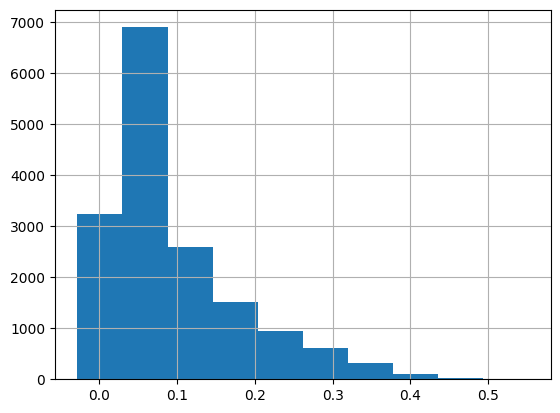

In [20]:
results_df['pred'].hist()

100%|██████████| 2034/2034 [00:59<00:00, 34.13it/s]


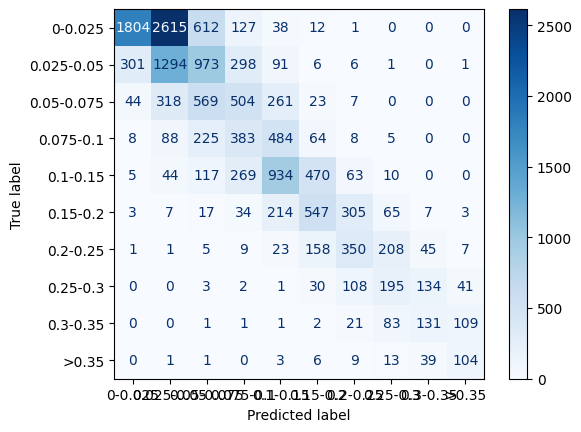

In [21]:


import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

# 显示混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()




In [22]:
print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.83      0.34      0.48      5339
  0.025-0.05       0.30      0.43      0.35      2978
  0.05-0.075       0.23      0.33      0.27      1727
   0.075-0.1       0.24      0.30      0.26      1265
    0.1-0.15       0.46      0.49      0.47      1912
    0.15-0.2       0.42      0.46      0.43      1202
    0.2-0.25       0.40      0.43      0.42       807
    0.25-0.3       0.34      0.38      0.36       514
    0.3-0.35       0.37      0.38      0.37       349
       >0.35       0.39      0.59      0.47       176

   micro avg       0.39      0.39      0.39     16269
   macro avg       0.40      0.41      0.39     16269
weighted avg       0.50      0.39      0.40     16269



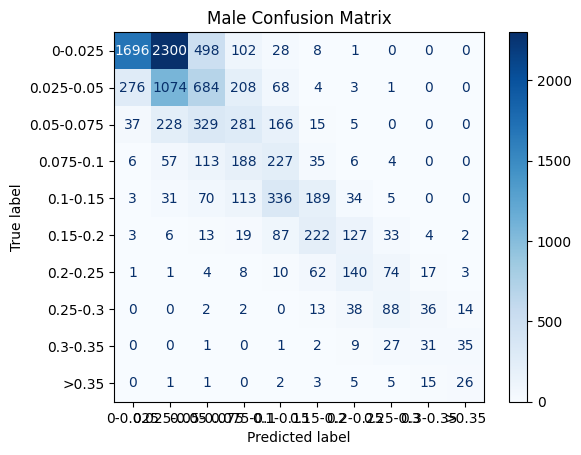

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.84      0.36      0.50      4759
  0.025-0.05       0.29      0.46      0.36      2325
  0.05-0.075       0.19      0.31      0.24      1062
   0.075-0.1       0.20      0.30      0.24       636
    0.1-0.15       0.36      0.43      0.39       781
    0.15-0.2       0.40      0.43      0.42       516
    0.2-0.25       0.38      0.44      0.41       320
    0.25-0.3       0.37      0.46      0.41       193
    0.3-0.35       0.30      0.29      0.30       106
       >0.35       0.33      0.45      0.38        58

   micro avg       0.39      0.38      0.39     10756
   macro avg       0.37      0.39      0.36     10756
weighted avg       0.53      0.38      0.41     10756



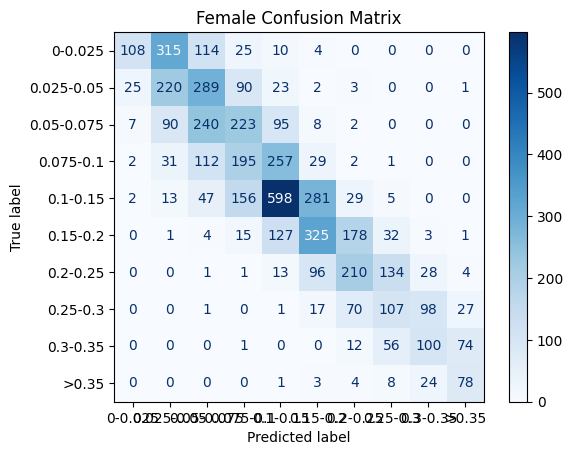

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.75      0.19      0.30       580
  0.025-0.05       0.33      0.34      0.33       653
  0.05-0.075       0.30      0.36      0.33       665
   0.075-0.1       0.28      0.31      0.29       629
    0.1-0.15       0.53      0.53      0.53      1131
    0.15-0.2       0.42      0.47      0.45       686
    0.2-0.25       0.41      0.43      0.42       487
    0.25-0.3       0.31      0.33      0.32       321
    0.3-0.35       0.40      0.41      0.40       243
       >0.35       0.42      0.66      0.51       118

   micro avg       0.40      0.40      0.40      5513
   macro avg       0.41      0.40      0.39      5513
weighted avg       0.43      0.40      0.39      5513



In [23]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # 显示混淆矩阵
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# 绘制男性混淆矩阵
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# 绘制女性混淆矩阵
plot_confusion_matrix(results_female, "Female Confusion Matrix")

In [24]:
metric_fn(results_male, results_female)

0.002332612480355155
0.0028553619690595594


0.0031167367134117617

## Evaluating your Test DataSet

In [40]:
# original
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename

In [33]:
### face mesh

'''
class faceDataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        

        return X, filename

'''

'\nclass faceDataset_test(torch.utils.data.Dataset):\n    \'Characterizes a dataset for PyTorch\'\n    def __init__(self, df, image_dir):\n         \'Initialization\'\n         self.image_dir = image_dir\n         self.df = df\n         self.transform = transforms.ToTensor()\n         \n    def __len__(self):\n        \'Denotes the total number of samples\'\n        return len(self.df)\n\n    def __getitem__(self, index):\n        \'Generates one sample of data\'\n        # Select sample\n        row = self.df.loc[index]\n        filename = row[\'filename\']\n\n        img_path = f"{self.image_dir}/{filename}"\n        img = cv2.imread(img_path)\n        landmarks = get_face_landmarks(img)\n        \n        if landmarks:\n            X = torch.tensor(landmarks).view(-1)\n        else:\n            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标\n        \n\n        return X, filename\n\n'

In [94]:
def is_grayscale(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    if np.array_equal(img_np[..., 0], img_np[..., 1]) and np.array_equal(img_np[..., 0], img_np[..., 2]):
        return True
    return False

# 使用该函数划分数据集
df_test['is_grayscale'] = df_test['filename'].apply(lambda x: is_grayscale(f"{image_dir}/{x}"))
df_test.head()


,filename,is_grayscale
0,database2/database2/test/0.jpg,False
1,database2/database2/test/1.jpg,False
2,database2/database2/test/2.jpg,True
3,database2/database2/test/3.jpg,False
4,database2/database2/test/4.jpg,False


In [145]:
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']
        is_gray = row['is_grayscale']
        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, is_gray, filename

test_set = Dataset_test(df_test, image_dir)
params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_loader = torch.utils.data.DataLoader(test_set, **params_test)


# 进行预测
results_list = []
for batch_idx, (X, is_gray, filename) in tqdm(enumerate(test_loader), total=len(test_loader)):
    X = X.to(device)
    for i in range(len(X)):  # 遍历批次中的每个图像
        if is_gray[i].item():  # 检查当前图像是否为黑白图像
            y_pred = model_grayscale(X[i].unsqueeze(0))  # 使用黑白模型预测，需要将图像扩展为单张图像的批次
        else:
            y_pred = model_color(X[i].unsqueeze(0))  # 使用彩色模型预测，需要将图像扩展为单张图像的批次
        
        # 获取预测值并将结果添加到结果列表中
        results_list.append({'pred': float(y_pred.squeeze().item())})

# 创建包含预测结果的DataFrame
test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [03:04<00:00, 20.67it/s]


In [41]:
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

In [42]:
results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [00:55<00:00, 68.36it/s]


In [146]:
test_df.head()

,pred
0,0.290960
1,0.318909
2,0.128874
3,0.302812
4,0.386916


### Preparing your file for Submission

In [147]:
test_df.to_csv("Data_Challenge.csv", header = None, index = None)

#### Now it's your turn. Good luck !  :) 